<a href="https://colab.research.google.com/github/castrokelly/eEDB-001-2023-4/blob/main/MVP_Regress%C3%A3o_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aprendizado de Máquina Supervisionado: Anúncios de redes sociais

Este é MVP para classificação de usuários que efetuaram ou não uma compra a partir de anuncios em redes sociais. Os dados estão disponibilizados na plataforma [Kaggle](https://www.kaggle.com/datasets/dragonheir/logistic-regression).


## Demandas

- Analisar a correlação dos dados dos usuários.
- Gerar um modelo de compra ou não por um usuário.
- Simular novas entradas de dados e previsões.

## Tópicos

1. Análise de medidas estatísticas dos dados
2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)
3. Correlação entre as variáveis
4. Criação do modelo de regressão logística
   1. Separação dos dados de treino e teste
   2. Treinamento do modelo
   3. Métricas do modelo
   4. Mapeamentos (predições) com novos dados
5. Conclusão


## Bibliotecas


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score)
from imblearn.over_sampling import SMOTE
from tabulate import tabulate


warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


## Carregamento dos dados


In [5]:
df = pd.read_csv('/content/Social_Network_Ads.csv', encoding='utf-8', sep=',')

## Detalhes do dataframe


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [7]:
df.sample(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
219,15732987,Male,59,143000,1
42,15772798,Male,35,108000,0
304,15598070,Female,40,60000,0
231,15694453,Male,39,42000,0
90,15684801,Male,22,81000,0
256,15609637,Female,41,72000,0
172,15794661,Female,26,118000,0
360,15577514,Male,43,129000,1
174,15644296,Female,34,72000,0
237,15753874,Female,37,80000,0


>> Renomeando as colunas

In [8]:
print("\nNomes originais das colunas\n\n", df.columns.to_list())

df.rename(columns={'User ID': 'id_usuario',
                   'Gender': 'genero',
                   'Age': 'idade',
                   'EstimatedSalary': 'salario_estimado',
                   'Purchased': 'comprado'},
          inplace=True)

print("\nNovos nomes das colunas\n\n", df.columns.to_list())



Nomes originais das colunas

 ['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']

Novos nomes das colunas

 ['id_usuario', 'genero', 'idade', 'salario_estimado', 'comprado']


>> Tamanho do data frame (dataset)

In [9]:
df.shape

(400, 5)

>> Removendo coluna que não será utilizada


In [10]:
df = df.drop(columns=['id_usuario'])

>>Verificando valores únicos


In [11]:
df.nunique()

genero                2
idade                43
salario_estimado    117
comprado              2
dtype: int64

>> Valores únicos dos Indicadores

In [12]:
genero_qtde = pd.DataFrame(df['genero'].value_counts().sort_index())
genero_qtde = genero_qtde.T
print(genero_qtde)

idade_qtde = pd.DataFrame(df['idade'].value_counts().sort_index())
idade_qtde = idade_qtde.T
print('\n', idade_qtde)

comprado_qtde = pd.DataFrame(df['comprado'].value_counts().sort_index())
comprado_qtde = comprado_qtde.T
print('\n', comprado_qtde)


        Female  Male
genero     204   196

        18  19  20  21  22  23  24  25  26  27  ...  51  52  53  54  55  56  \
idade   5   7   7   4   5   6   9   6  16  13  ...   3   6   5   4   3   3   

       57  58  59  60  
idade   5   6   7   7  

[1 rows x 43 columns]

             0    1
comprado  257  143


>> Abrindo os valores da categoria 'genero' em categorias distintas e traduzindo (português) os valores da categoria 'genero'

In [13]:
arr_genero = OneHotEncoder().fit_transform(
    df['genero'].values.reshape(-1, 1)).toarray()
df_genero = pd.DataFrame(arr_genero)
df_genero.rename(columns={0: 'feminino', 1: 'masculino'}, inplace=True)
df = pd.concat([df, df_genero], axis=1)
df['genero'].replace({'Male': 'Masculino', 'Female': 'Feminino'}, inplace=True)
df.head(10)

,genero,idade,salario_estimado,comprado,feminino,masculino
0,Masculino,19,19000,0,0.0,1.0
1,Masculino,35,20000,0,0.0,1.0
2,Feminino,26,43000,0,1.0,0.0
3,Feminino,27,57000,0,1.0,0.0
4,Masculino,19,76000,0,0.0,1.0
5,Masculino,27,58000,0,0.0,1.0
6,Feminino,27,84000,0,1.0,0.0
7,Feminino,32,150000,1,1.0,0.0
8,Masculino,25,33000,0,0.0,1.0
9,Feminino,35,65000,0,1.0,0.0


>> Tipos de dados


In [14]:
df.dtypes

genero               object
idade                 int64
salario_estimado      int64
comprado              int64
feminino            float64
masculino           float64
dtype: object

>> Valores Nulos (Ausentes)

In [15]:
df.isnull().sum()

genero              0
idade               0
salario_estimado    0
comprado            0
feminino            0
masculino           0
dtype: int64

In [16]:
df.sample(10)

,genero,idade,salario_estimado,comprado,feminino,masculino
171,Masculino,34,115000,0,0.0,1.0
323,Feminino,48,30000,1,1.0,0.0
39,Feminino,27,31000,0,1.0,0.0
360,Masculino,43,129000,1,0.0,1.0
204,Feminino,58,101000,1,1.0,0.0
128,Masculino,30,17000,0,0.0,1.0
156,Masculino,46,59000,0,0.0,1.0
394,Feminino,39,59000,0,1.0,0.0
377,Feminino,42,53000,0,1.0,0.0
288,Masculino,41,79000,0,0.0,1.0


## 1. Análise dos dados
>>### Função para gerar gráficos boxplot
>>>param1: coluna do dataframe

>>>param2: label para gráfico

>>>param3: axis

>>>param4: cor, defaut: 'yellowgreen'

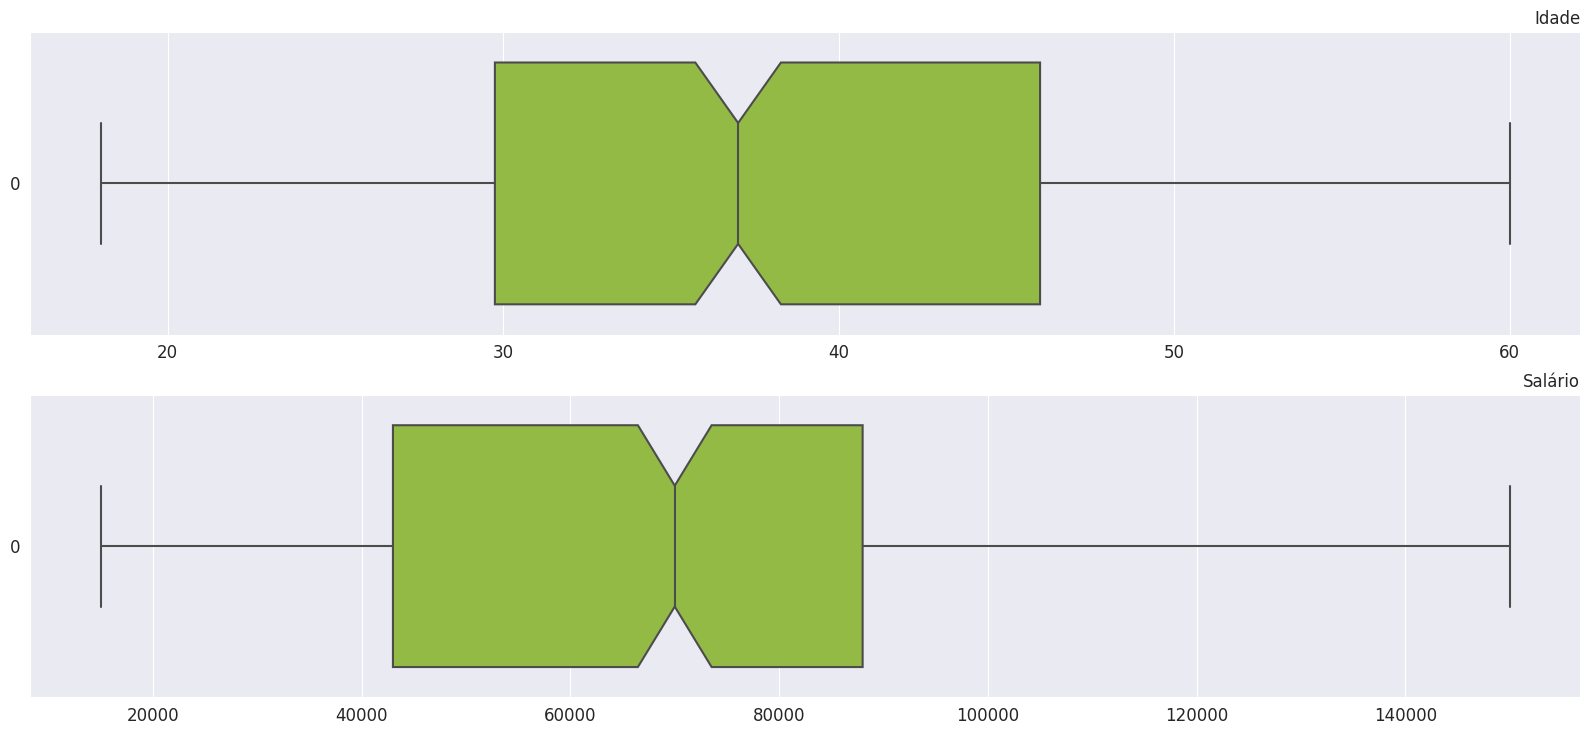

In [17]:
def graf_boxplot(param1, param2, param3, param4='yellowgreen'):
    sns.boxplot(data=param1, ax=param3, color=param4, notch=True, orient='h')
    param3.set(xlabel='', ylabel='')
    param3.tick_params(labelsize=12)
    param3.ticklabel_format(style='plain', axis='x')
    param3.set_title(param2, loc='right', fontsize=12)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 7))

graf_boxplot(df['idade'], 'Idade', ax1)
graf_boxplot(df['salario_estimado'], 'Salário', ax2)

plt.subplots_adjust(top=1.9, bottom=0.95)
plt.show()


In [18]:
df[['idade', 'salario_estimado']].describe().T

,count,mean,std,min,25%,50%,75%,max
idade,400.0,37.655,10.482877,18.0,29.75,37.0,46.0,60.0
salario_estimado,400.0,69742.500,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0



>>### Função para gerar gráficos stripplot
>>>param1: nome do dataframe

>>>param2: variável do eixo X

>>>param3: variável do eixo Y

>>>param4: axis

>>>param5: spec

>>>param6: label para gráfico

>>>param7: paleta de cores, default: Dark2

In [19]:
comprado = df['comprado'].replace({1: 'Sim', 0: 'Não'})

def graf_2_stripplot(param1, param2, param3, param4, param5, param6, param7='Dark2'):
    param4 = fig.add_subplot(param5)
    sns.stripplot(data=param1, x=param2, y=param3,
                  ax=param4, hue=comprado, palette=param7, s=7, alpha=0.7)
    param4.set(xlabel='', ylabel='')
    param4.legend(title='Comprado\n', fontsize=12, title_fontsize=12)
    param4.tick_params(labelsize=12)
    param4.ticklabel_format(style='plain', axis='y')
    param4.set_title(param6, fontsize=15)

>>Gráficos

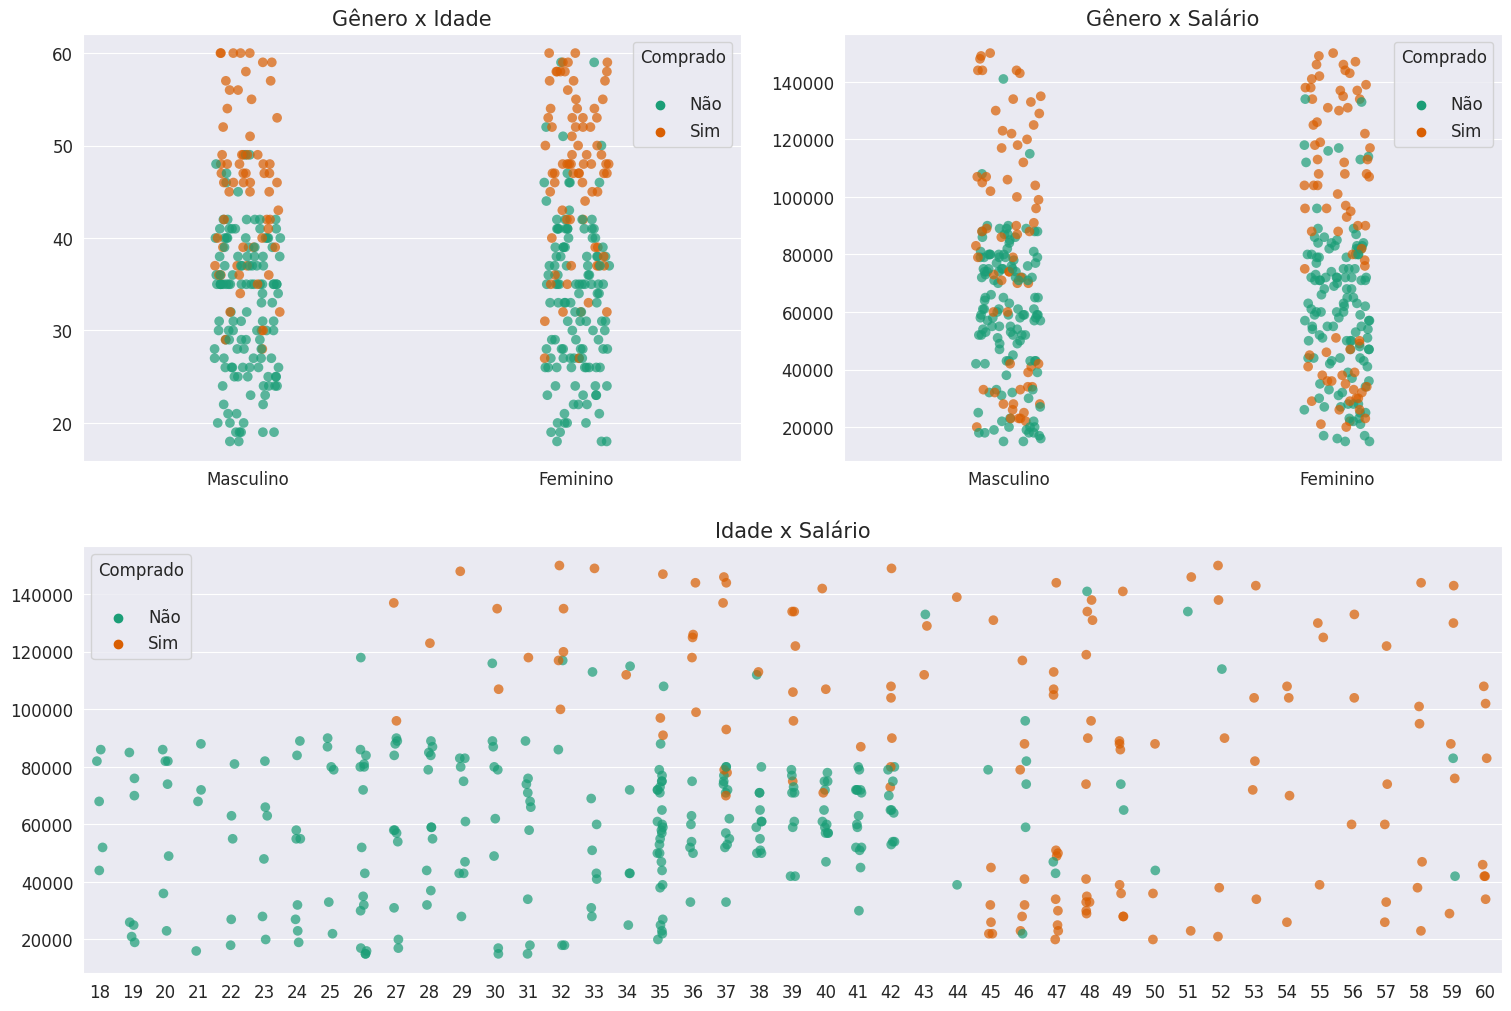

In [20]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

ax1 = ax2 = ax3 = None

graf_2_stripplot(df, 'genero', 'idade', ax1, spec[0, 0],
                 'Gênero x Idade')
graf_2_stripplot(df, 'genero', 'salario_estimado', ax2, spec[0, 1],
                 'Gênero x Salário')
graf_2_stripplot(df, 'idade', 'salario_estimado', ax3, spec[1, 0:],
                 '\nIdade x Salário')
plt.show()


>>### Função para gerar gráficos displot
>>> param1: nome do dataframe

>>> param2: variável do eixo X

>>> param3: label para gráfico

>>> param4: cor, default: royalblue

In [21]:
def graf_displot(param1, param2, param3, param4='royalblue'):
    plot = sns.displot(data=param1, x=param2, col=comprado,
                       color=param4, kde=True, bins=20, hue=comprado, legend=False)
    #plot.tick_params(labelsize=12)
    plot.set_axis_labels(param3, 'Contagem\n', size=12)
    plot.set_titles('Comprado: {col_name}', size=13)
    plot.figure.set_size_inches(10, 5)

>>Gráficos

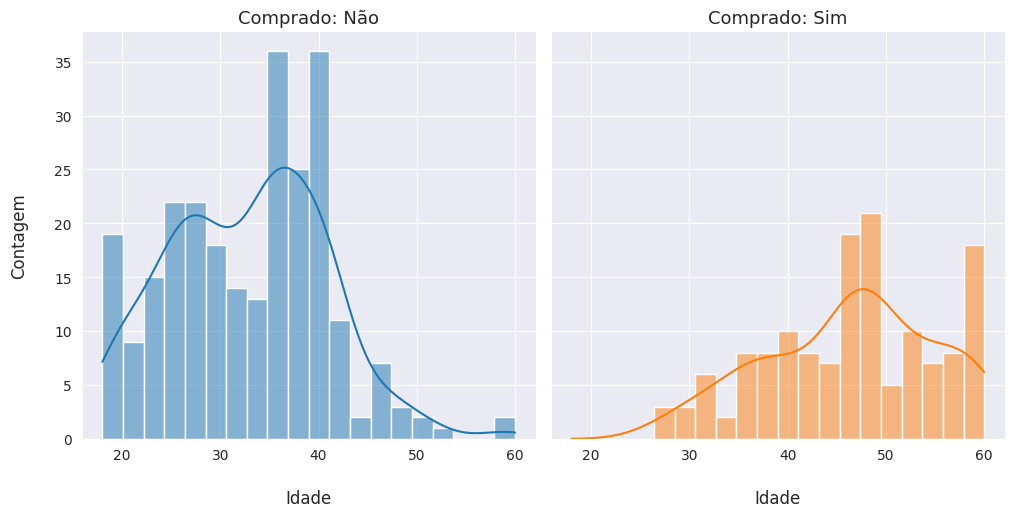

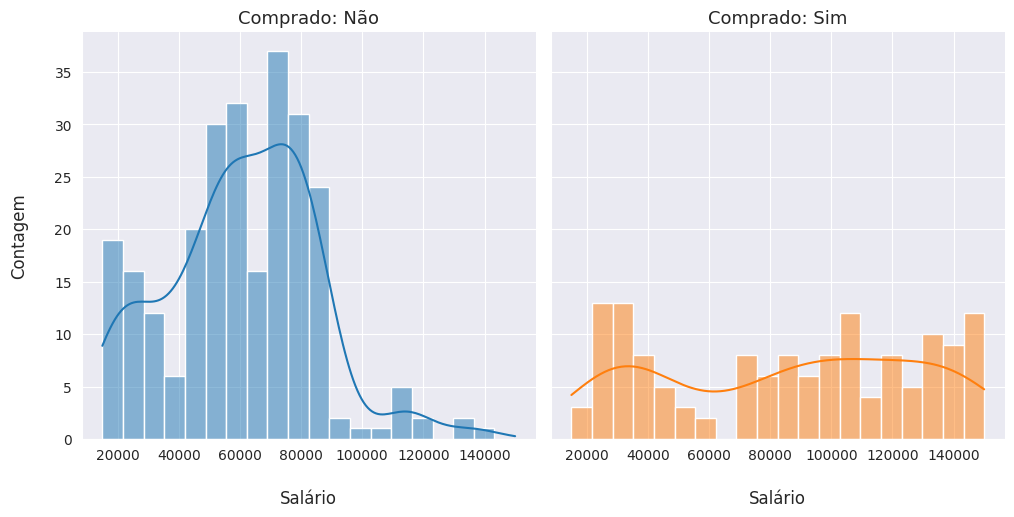

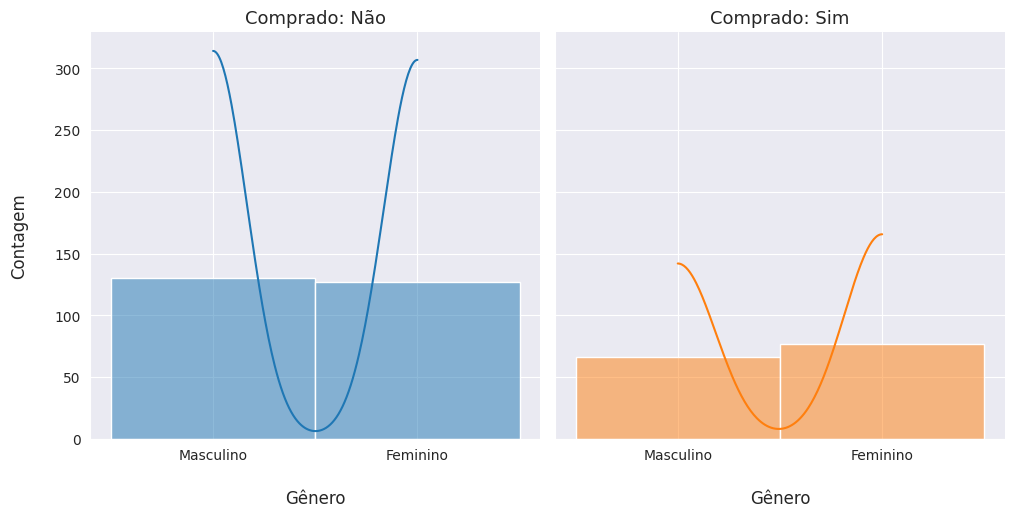

In [22]:
graf_displot(df, 'idade', '\nIdade')
graf_displot(df, 'salario_estimado', '\nSalário')
graf_displot(df, 'genero', '\nGênero')
plt.show()

## 2. Correlação entre as variáveis


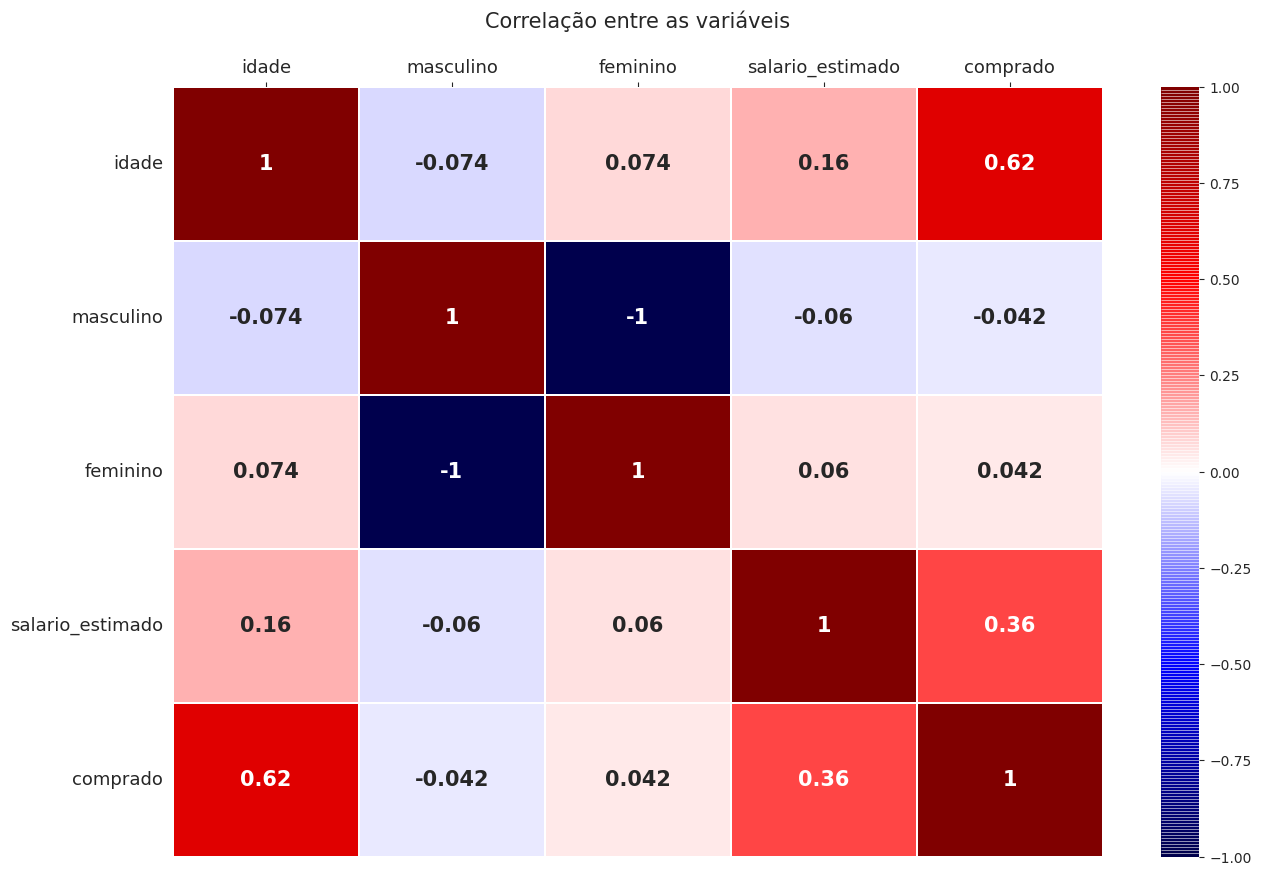

In [23]:
corr = df[['idade', 'masculino', 'feminino',
           'salario_estimado', 'comprado', ]].corr()

plt.figure(figsize=(15, 10))
plot = sns.heatmap(data=corr,
                   annot=True, annot_kws={'size': 15, 'fontweight': 'bold'},
                   cbar_kws={'extendfrac': .1, 'drawedges': True},
                   cmap='seismic', vmin=-1, linewidths=.2,
                   xticklabels=['idade', 'masculino', 'feminino',
                                'salario_estimado', 'comprado'],
                   yticklabels=['idade', 'masculino', 'feminino',
                                'salario_estimado', 'comprado']
                   )
plot.set_yticklabels(plot.get_yticklabels(), rotation=0)
plot.set_title('Correlação entre as variáveis\n', loc='center', fontsize=15)
plot.tick_params(labelsize=13)
plot.xaxis.tick_top()
plt.show()


## 3. Criação do modelo de Regressão Logística


## Escala
A padronização (**StandardScaler**) é um processo estatístico que transforma os dados de tal forma que eles tenham uma média zero e um desvio padrão unitário.

**MinMaxScaler**:

Esta técnica dimensiona os dados para um intervalo específico, geralmente entre 0 e 1. O MinMaxScaler é útil quando se deseja  manter a distribuição relativa dos dados acompanhado da presença alguns poucos outliers.

**RobustScaler**:

O RobustScaler é útil quando os dados contêm maior presença outliers. Ele padroniza os dados usando estatísticas robustas, como a mediana e o intervalo interquartil.

**Normalização L1 ou L2**:

A normalização L1 (Norma L1) divide cada valor em uma linha pelo somatório dos valores absolutos naquela linha. A normalização L2 (Norma Euclidiana) divide cada valor em uma linha pelo somatório dos quadrados dos valores naquela linha.


In [24]:
# features (variáveis independentes)
X = df.drop(['comprado', 'genero'], axis=1)
# padronizando os dados das features
std = StandardScaler().fit(X)
X = std.transform(X)

### Separação dos dados para treinamento e teste


In [25]:
print(X)

[[-1.78179743 -1.49004624 -1.02020406  1.02020406]
 [-0.25358736 -1.46068138 -1.02020406  1.02020406]
 [-1.11320552 -0.78528968  0.98019606 -0.98019606]
 ...
 [ 1.17910958 -1.46068138  0.98019606 -0.98019606]
 [-0.15807423 -1.07893824 -1.02020406  1.02020406]
 [ 1.08359645 -0.99084367  0.98019606 -0.98019606]]


In [26]:
# target (variável dependente)
y = df['comprado'].copy()

# definindo o percentual de dados para teste
perc = 0.25

# definindo o random_state
seed = 10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=perc, random_state=seed)

print('\nQuantidade de dados divididos em treino e teste')
print('\nX_train:', X_train.shape)
print('y_train:', y_train.shape)
print('\nX_test:', X_test.shape)
print('y_test:', y_test.shape)



Quantidade de dados divididos em treino e teste

X_train: (300, 4)
y_train: (300,)

X_test: (100, 4)
y_test: (100,)


### Balanceamento dos dados
>>SMOTE: Esta é uma classe do pacote imbalanced-learn, que é uma extensão do scikit-learn projetada para lidar com conjuntos de dados desbalanceados, onde uma categoria tem uma quantidade de amostras significativamente menor que a outra.

**sampling_strategy='minority'**: Esse parâmetro especifica a classe de interesse (a classe minoritária). No caso, 'minority' significa se está se concentrando na classe minoritária. A ideia é gerar exemplos sintéticos para essa classe para equilibrar o conjunto de dados.

**random_state=42**: Este é um argumento opcional que define a semente para a geração de números aleatórios. Definir um valor para random_state garante que o processo de oversampling seja reproduzível, ou seja, ao executar o mesmo código várias vezes com a mesma semente, se obterá os mesmos resultados.

O procedimento  SMOTE envolve selecionar uma instância da classe minoritária e, em seguida, encontrar seus vizinhos mais próximos ( k vizinhos mais próximos). Com base nessas instâncias, o SMOTE cria novas instâncias sintéticas interpolando características entre a instância original e seus vizinhos mais próximos.

In [27]:
print("\nDesbalanceado")
print(y_train.value_counts())

sample = SMOTE(sampling_strategy='minority', random_state=42)

X_train_b, y_train_b = sample.fit_resample(X_train, y_train)

print("\nBalanceado")
print(y_train_b.value_counts())



Desbalanceado
0    188
1    112
Name: comprado, dtype: int64

Balanceado
0    188
1    188
Name: comprado, dtype: int64


### Regressão Logística

A regressão logística é um algoritmo de aprendizado supervisionado usado para classificação. O solver é o método usado para otimizar a função de custo, e diferentes solvers são adequados para diferentes tipos de conjuntos de dados. O 'liblinear' é uma escolha comum para conjuntos de dados pequenos considerando a combinação de linhas e colunas do df).

Contudo, a biblioteca scikit-learn oferece vários solvers para a regressão logística, cada um com suas próprias características e adequado para diferentes tipos de problemas. Aqui estão alguns dos solvers disponíveis e uma breve descrição de suas utilidades:

1. **newton-cg (Newton Conjugate Gradient):**
   - Este solver usa o método de otimização de Newton.Pode ser lento em grandes conjuntos de dados.

2. **lbfgs (Limited-memory Broyden–Fletcher–Goldfarb–Shanno):**
   - Este solver usa uma aproximação do método BFGS com memória limitada. É adequado para grandes conjuntos de dados e é mais eficiente do que 'newton-cg' para muitas amostras.

3. **liblinear:**
   - Este solver é bom para conjuntos de dados pequenos a médios. Ele é eficaz para problemas de classificação binária e multiclasse.

4. **sag (Stochastic Average Gradient):**
   - Este solver usa uma versão estocástica do método de gradiente médio. É especialmente eficiente quando o número de amostras (linhas) é grande.

5. **saga (SAGA - Shuffled Aggregated Gradient Algorithm):**
   - Uma versão otimizada do solver 'sag'.

A escolha do solver depende do tamanho do conjunto de dados, da natureza do problema e dos requisitos computacionais. Em geral, 'liblinear' é uma escolha sólida para conjuntos de dados pequenos, enquanto 'lbfgs', 'sag' e 'saga' são mais eficientes para conjuntos de dados maiores. 'newton-cg' pode ser uma boa escolha , mas pode ser lento para conjuntos de dados grandes.

In [28]:
# O 'liblinear' é utilizado para conjuntos de dados com uma quantidade pequena de amostras
modelo_rl = LogisticRegression(solver='liblinear')
print('\nModelo selecionado:', modelo_rl)


Modelo selecionado: LogisticRegression(solver='liblinear')


### Treinamento (ajuste) do modelo


In [29]:
# treinamento do modelo
modelo_rl.fit(X_train_b, y_train_b)

# predição com dados de teste
pred_test = modelo_rl.predict(X_test)

pred_test


array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

### 3. Métricas do modelo


>>Acurácia Preditiva

In [30]:
acuracia = accuracy_score(y_test, pred_test) * 100
print('\nO modelo obteve %0.2f de acurácia.' % acuracia)


O modelo obteve 90.00 de acurácia.


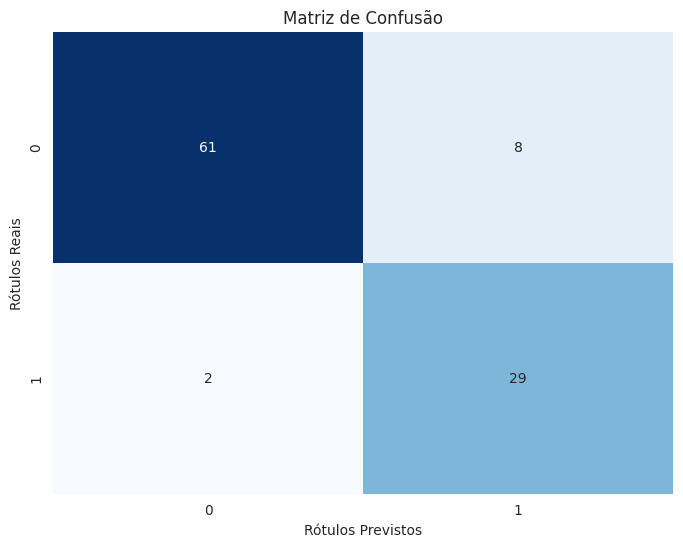

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, pred_test)

# Criando um DataFrame do Pandas para facilitar a manipulação dos dados
confusion_df = pd.DataFrame(matrix, index=['0', '1'], columns=['0', '1'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Reais')
plt.title('Matriz de Confusão')
plt.show()


>>Desempenho global
>>>**Precision**: percentual de acerto ao classificar uma predição em verdadeira positiva (1 - sim) em relação as predições verdadeiras e falsas positivas.

>>>**Recall**: percentual de acerto ao classificar uma predição em verdadeira positiva (1 - sim) em relação as predições verdadeiras positivas e falsas negativas.

>>>**F1-score**: média ponderada entre 'precision' e 'recall'.

>>>**Support**: número de classificações das predições.


In [32]:
print('\n', classification_report(y_test, pred_test))


               precision    recall  f1-score   support

           0       0.97      0.88      0.92        69
           1       0.78      0.94      0.85        31

    accuracy                           0.90       100
   macro avg       0.88      0.91      0.89       100
weighted avg       0.91      0.90      0.90       100



>> Curva ROC

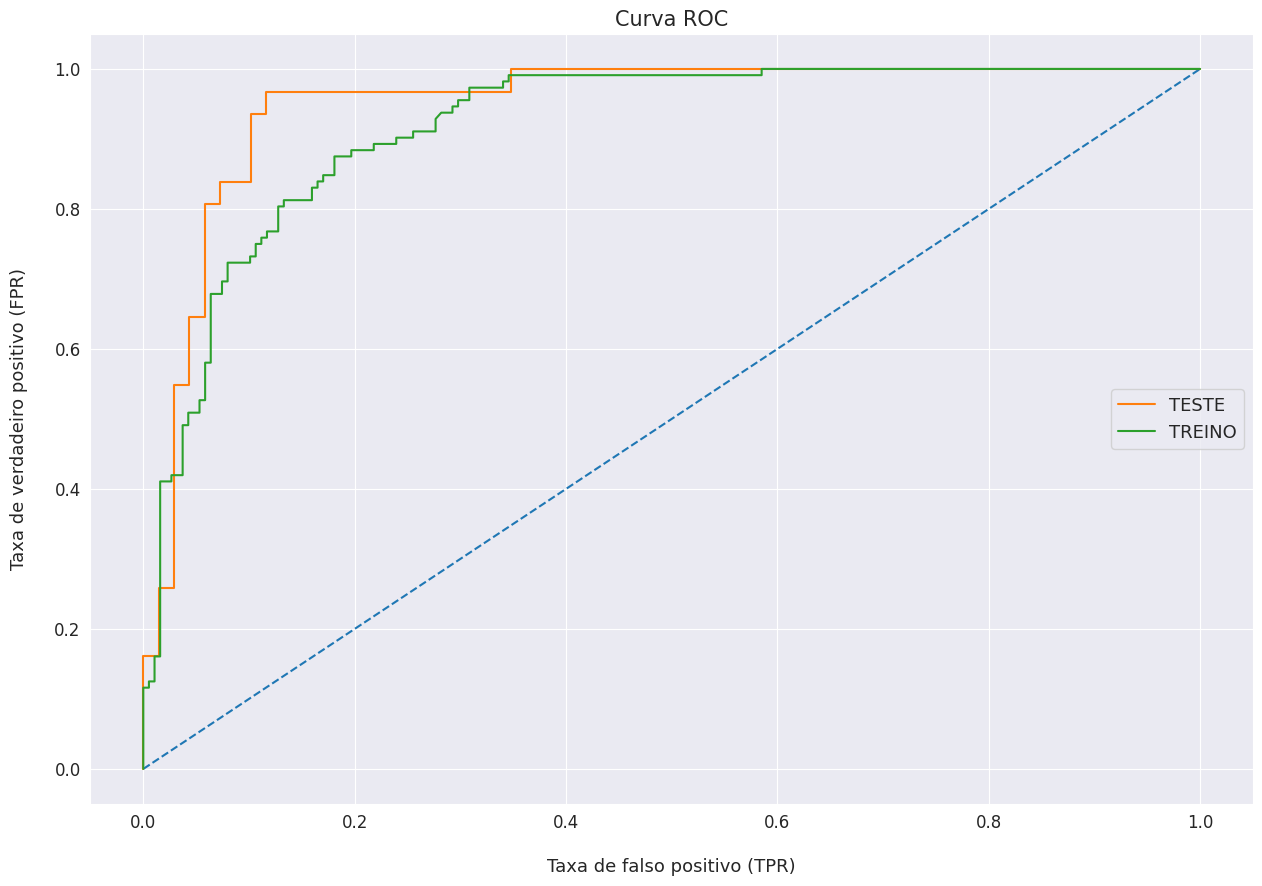

In [33]:
# Calculando as probabilidades com dados de treino e teste
pred_test_prob = modelo_rl.predict_proba(X_test)[:, 1]
pred_train_prob = modelo_rl.predict_proba(X_train)[:, 1]

# Gera fpr (Taxa de falso positivo), tpr (Taxa de falso positivo) e thresholds
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_test_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_train, pred_train_prob)

# Gráfico da curva ROC
plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr1, tpr1, label='TESTE')
plt.plot(fpr2, tpr2, label='TREINO')
plt.tick_params(labelsize=12)
plt.xlabel('\nTaxa de falso positivo (TPR)', fontsize=13)
plt.ylabel('Taxa de verdadeiro positivo (FPR)\n', fontsize=13)
plt.title('Curva ROC', fontsize=15)
plt.legend(loc='center right', fontsize=13)
plt.show()


>>>AUC - Área sob a curva ROC

In [34]:
# Calculando o AUC (Área sob a curva ROC)
auc_score_test = roc_auc_score(y_test, pred_test_prob)
auc_score_train = roc_auc_score(y_train, pred_train_prob)

print('\nAUC dados de teste: ', auc_score_test)
print('\nAUC dados de treino:', auc_score_train)



AUC dados de teste:  0.9495091164095372

AUC dados de treino: 0.9191441869300913


##Questões
1. Explique o conceito de multicolinearidade em regressão logística. Como ela pode impactar a interpretação dos coeficientes e a estabilidade do modelo?

2. Em que situações a seleção de features (feature selection) ou a redução de dimensionalidade (dimensionality reduction) seriam benéficas ao aplicar a regressão logística? Forneça exemplos práticos.

3. Descreva o processo de ajuste de hiperparâmetros (tuning) em um modelo de regressão logística. Quais hiperparâmetros são comumente ajustados e por que isso é importante?

4. *(Programação):*
   - Implemente uma rotina em Python que realiza a validação cruzada no treinamento do modelo de regressão logística. A função deve aceitar dados de features, rótulos, o modelo a ser treinado e o número de folds como parâmetros, retornando as métricas de desempenho em cada fold. Utilize bibliotecas como scikit-learn.

In [37]:
from sklearn.model_selection import cross_val_score

def logistic_regression_cv(X, y, model, num_folds):
    """
    Realiza validação cruzada para modelo de regressão logística.

    Parâmetros:
    - X: Conjunto de features.
    - y: Variável dependente.
    - model: Modelo de regressão logística.
    - num_folds: Número de folds para validação cruzada.

    Retorna:
    - Lista de métricas de desempenho para cada fold.
    """
    scores = cross_val_score(model, X, y, cv=num_folds, scoring='accuracy')
    return scores

# Exemplo de uso
modelo = LogisticRegression(solver='liblinear', random_state=42)
resultados_cv = logistic_regression_cv(X_train_b, y_train_b, modelo, num_folds=5)

# Exibindo os resultados
print("Acurácia p/ cada fold:", resultados_cv)
print("Acurácia média:", np.mean(resultados_cv))


Acurácia p/ cada fold: [0.85526316 0.82666667 0.82666667 0.8        0.85333333]
Acurácia média: 0.8323859649122808
